### Using Real-world Images

**OBS.: NO COLAB, UTILIZE UMA MÁQUINA COM GPU PARA ESTE EXEMPLO**

### Lab 03: Efeitos da utilização de imagens compactadas no treinamento

O uso de imagens de menores dimensões exige um menor custo computacional, resultando muitas vezes em um treinamento mais rápido. Porém, existe a possibilidade de uma imagem menor não ser capaz de representar corretamente as features que representam diferenças entre as classes, diminuindo a acurácia do modelo.

A técnica de compactação pode ser utilizada num período de exploração nos projetos. Sempre será necessário avaliar se o compromisso entre maior velocidade de treinamento e performance do modelo vale a pena.

Vamos explorar o impacto da redução das dimensões das imagens do dataset `horse-or-human` na performance do modelo de classificação.

Esse redimensionamento é facilitado pela método `tf.keras.utils.image_dataset_from_directory`.

Importando as bibliotecas necessárias.

In [40]:
import os
import random
import numpy as np

# Para plotar e lidar com imagens:
import matplotlib.pyplot as plt

import tensorflow as tf

#### Carregando os Datasets

Definimos os diretórios com as imagens para treinamento (`horse-or-human`) e para validação (`validation-horse-or-human`).

##### Para o colab:

In [50]:
# Montando o drive
from google.colab import drive
drive.mount('/content/drive')

# Pasta do curso:
course_dir = "/content/drive/MyDrive/Cursos/Introduction to TensorFlow for AI, ML, and DL/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Pasta onde as imagens para treinamento estão, deve ser o caminho para a pasta "horse-or-human"
TRAIN_DIR = course_dir+'data/horse-or-human'
# Pasta onde as imagens para validação estão, deve ser o caminho para a pasta "validation-horse-or-human"
VAL_DIR = course_dir+'data/validation-horse-or-human'

# Pasta com as imagens de cavalos para o treinamento
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')
# Pasta com as imagens de hunanos para o treinamento
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Pasta com as imagens de cavalos para a validação
validation_horse_dir = os.path.join(VAL_DIR, 'horses')
# Pasta com as imagens de humanos para a validação
validation_human_dir = os.path.join(VAL_DIR, 'humans')

##### Para o jupyter:

In [41]:
# Pasta do curso:
course_dir = os.getcwd()

# Pasta onde as imagens para treinamento estão, deve ser o caminho para a pasta "horse-or-human"
TRAIN_DIR = course_dir+'\\data\\horse-or-human'
# Pasta onde as imagens para validação estão, deve ser o caminho para a pasta "validation-horse-or-human"
VAL_DIR = course_dir+'\\data\\validation-horse-or-human'

# Pasta com as imagens de cavalos para o treinamento
train_horse_dir = os.path.join(TRAIN_DIR, 'horses')
# Pasta com as imagens de hunanos para o treinamento
train_human_dir = os.path.join(TRAIN_DIR, 'humans')

# Pasta com as imagens de cavalos para a validação
validation_horse_dir = os.path.join(VAL_DIR, 'horses')
# Pasta com as imagens de humanos para a validação
validation_human_dir = os.path.join(VAL_DIR, 'humans')

#### Pré-processamento dos dados:

Instanciando os datasets, reescalando as imagens e configurando os datasets.

A única diferença é que agora, ao instanciar os datasets, definimos o tamanho das nossas imagens para `(150,150)` ao invés de `(300,300)`. A `tf.keras.utils.image_dataset_from_directory` redimensiona as imagens automaticamente ao ler os dados das pastas.

In [42]:
# Instancia o dataset de treinamento
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)

# Instancia o dataset de validação
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(150, 150),
    batch_size=32,
    label_mode='binary'
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [43]:
# Definindo a camada de redimensionamento
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)

# Normaliza as imagens usando a função lambda
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
validation_dataset_scaled = validation_dataset.map(lambda image, label: (rescale_layer(image), label))

In [44]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

# Configura o dataset de treinamento
train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

# Configura o dataset de validação
validation_dataset_final = (validation_dataset_scaled
                           .cache()
                           .prefetch(PREFETCH_BUFFER_SIZE)
)

#### Construindo nosso modelo

Seguindo a mesma arquitetura dos modelos criados neste notebook, as diferenças estão no `input_shape`, que agora será `(150,150,3)` para nossas imagens redimensionadas, e a diminuição no número de camadas de Convolução+MaxPooling. Como nossos dados tem uma menor complexidade (1/4 do número de pixels utilizados anteriormente), podemos reduzir a complexidade da Rede.

In [45]:
model = tf.keras.models.Sequential([
    # Note que o formato da entrada é o formato da imagem no dataset, de 150x150 com 3 bytes de cor
    tf.keras.Input(shape=(150, 150, 3)),
    # Primeira convolução
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolução
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Terceira convolução
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     # Quarta convolução
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Quinta convolução
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    # Passa os resultados para um vetor unidimensional, para dar de entrada à rede densa
    tf.keras.layers.Flatten(),
    # 512 neurônios na camada oculta
    tf.keras.layers.Dense(512, activation='relu'),
    # Somente 1 neurônio de saída. Nele estará o valor 0 ou 1, sendo 0 para 'cavalos' e 1 para 'humanos'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

#### Treinamento

No treinamento é interessante notar a velocidade comparada ao modelo do Lab02 e as acurácias nos conjuntos de treino e validação.

In [47]:
history = model.fit(
    train_dataset_final,
    epochs=15,
    validation_data = validation_dataset_final,
    verbose=2
)

Epoch 1/15
33/33 - 14s - loss: 0.7196 - accuracy: 0.6680 - val_loss: 0.3903 - val_accuracy: 0.8633 - 14s/epoch - 427ms/step
Epoch 2/15
33/33 - 12s - loss: 0.2222 - accuracy: 0.9056 - val_loss: 0.8777 - val_accuracy: 0.8438 - 12s/epoch - 377ms/step
Epoch 3/15
33/33 - 12s - loss: 0.0953 - accuracy: 0.9659 - val_loss: 0.9069 - val_accuracy: 0.8398 - 12s/epoch - 378ms/step
Epoch 4/15
33/33 - 13s - loss: 0.1213 - accuracy: 0.9523 - val_loss: 0.8034 - val_accuracy: 0.8594 - 13s/epoch - 380ms/step
Epoch 5/15
33/33 - 13s - loss: 0.0405 - accuracy: 0.9844 - val_loss: 0.6750 - val_accuracy: 0.8789 - 13s/epoch - 382ms/step
Epoch 6/15
33/33 - 13s - loss: 0.0782 - accuracy: 0.9796 - val_loss: 2.1466 - val_accuracy: 0.7812 - 13s/epoch - 382ms/step
Epoch 7/15
33/33 - 13s - loss: 0.0982 - accuracy: 0.9727 - val_loss: 1.2010 - val_accuracy: 0.8633 - 13s/epoch - 379ms/step
Epoch 8/15
33/33 - 13s - loss: 0.0102 - accuracy: 0.9981 - val_loss: 3.1277 - val_accuracy: 0.7734 - 13s/epoch - 393ms/step
Epoch 9/

Plotando a evolução da acurácia de treino e validação em cada época de treinamento:

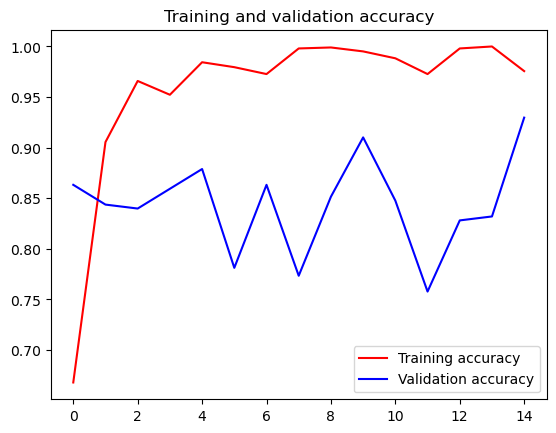

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

#### Testando o modelo com imagens da internet.

##### Para o Google Colab

Abre uma pequena interface para upload das imagens para predição.

In [59]:
from google.colab import files

# Lista na qual as imagens serão armazenadas
uploaded = files.upload()

# Itera sobre as imagens para realizar a predição
for filename in uploaded.keys():
    # Imagens para predição:
    path = '/content/'+filename
    # Carrega a imagem
    image = tf.keras.utils.load_img(path, target_size=(150,150))
    image = tf.keras.utils.img_to_array(image)
    # Usa a função definida anteriormente para normalizar a imagem
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    # Realiza a predição
    prediction = model.predict(image, verbose=0)[0][0]
    print(f"\nSaída do modelo: {prediction}")

    # Para nosso classificador binário, a saída é próxima a 0 para uma classe e próximo a 1 para a outra
    if prediction > 0.5:
        print(filename + " é um humano.")
    else:
        print(filename + " é um cavalo.")

Saving animal-4402382_1280.jpg to animal-4402382_1280 (2).jpg
Saving horse-1139142_1280.jpg to horse-1139142_1280 (3).jpg
Saving horse-8472924_1280.jpg to horse-8472924_1280 (3).jpg
Saving human-3782189_1280.jpg to human-3782189_1280 (3).jpg
Saving man-8493244_1280.jpg to man-8493244_1280 (3).jpg
Saving white-horse-1136093_1280.jpg to white-horse-1136093_1280 (3).jpg
Saving white-horse-3010129_1280.jpg to white-horse-3010129_1280 (3).jpg
Saving woman-1869158_1280.jpg to woman-1869158_1280 (3).jpg
Saving woman-5948094_1280.jpg to woman-5948094_1280 (3).jpg

Saída do modelo: 1.0758312640746226e-07
animal-4402382_1280 (2).jpg é um cavalo.

Saída do modelo: 0.003648903453722596
horse-1139142_1280 (3).jpg é um cavalo.

Saída do modelo: 0.10631619393825531
horse-8472924_1280 (3).jpg é um cavalo.

Saída do modelo: 1.0
human-3782189_1280 (3).jpg é um humano.

Saída do modelo: 1.0
man-8493244_1280 (3).jpg é um humano.

Saída do modelo: 1.0
white-horse-1136093_1280 (3).jpg é um humano.

Saída do

##### Para o Jupyter

Abre uma pequena interface para upload das imagens para predição.

In [49]:
from io import BytesIO

# Widgets interativos para o jupyter:
from ipywidgets import widgets

# Cria um widget para dar upload nas imagens
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ Faz a predição da imagem e printa a saída."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0][0]

    with out:
        if prediction > 0.5:
            print(filename + " é um humano.")
        else:
            print(filename + " é um cavalo.")


def on_upload_change(change):
    """ Pega os arquivos do widget e faz a predição."""
    # Pega o(s) arquivo(s) do upload
    items = change.new

    for item in items: # Loop para o caso de mais de um arquivo
        file_jpgdata = BytesIO(items[item]['content'])
        file_predict(items[item]['metadata']['name'], file_jpgdata, out)

# Roda o widget interativo
# Nota: após a seleção das imagens, a predição pode demorar um pouco para ser printada.
uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

#### Uma última observação sobre o modelo:

**OBS.:** Novamente, os erros apresentados nos modelos podem variar, os citados abaixo foram obtidos na execução do Google Colab, onde o resultado obtido foi: 

```
Saída do modelo: 1.0758312640746226e-07
animal-4402382_1280 (2).jpg é um cavalo.

Saída do modelo: 0.003648903453722596
horse-1139142_1280 (3).jpg é um cavalo.

Saída do modelo: 0.10631619393825531
horse-8472924_1280 (3).jpg é um cavalo.

Saída do modelo: 1.0
human-3782189_1280 (3).jpg é um humano.

Saída do modelo: 1.0
man-8493244_1280 (3).jpg é um humano.

Saída do modelo: 1.0
white-horse-1136093_1280 (3).jpg é um humano.

Saída do modelo: 0.19685772061347961
white-horse-3010129_1280 (3).jpg é um cavalo.

Saída do modelo: 0.9999973773956299
woman-1869158_1280 (3).jpg é um humano.

Saída do modelo: 0.9983742237091064
woman-5948094_1280 (3).jpg é um humano.
```

**Continuação OBS.:** Podemos ver que novamente na segunda execução, realizada no Jupyter, os resultados obtidos foram um pouco diferentes. Inclusive, para as imagens de teste escolhidas, conseguimos obter no modelo do Google Colab, um resultado melhor com as imagens comprimidas (em `150x150`) que para as sem a compressão (em `300x300`). Mas no Jupyter, obtivemos mais erros. Novamente, isso mostra como os modelos podem variar bastante entre execuções, principalmente quando treinamos para poucas épocas e com poucos dados.

Partindo para a análise:

Neste modelo, apenas nosso cavalo que foi erroneamente classificado em todos outros modelos manteve o erro.

<img src="https://cdn.pixabay.com/photo/2016/01/12/16/51/white-horse-1136093_1280.jpg" width="500"></img>

Já no Jupyter, tivemos o anjo sendo incorretamente classificado para todos os modelos, assim como o cavalo acima. Ainda, algumas das outras imagens incorretamente classificadas:

<img src="https://cdn.pixabay.com/photo/2014/12/08/17/52/horse-561221_1280.jpg" width="500"></img>

<img src="https://cdn.pixabay.com/photo/2021/01/25/11/29/woman-5948094_1280.jpg" width="500"></img>

<img src="https://cdn.pixabay.com/photo/2015/05/02/08/02/angel-749625_1280.jpg" width="500"></img>


#### Visualizando as representações intermediárias das camadas de convolução

Plotando como as features são transformadas ao longo de cada camada.

C:\Users\lara2\AppData\Local\Temp\ipykernel_6128\242988790.py:39: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


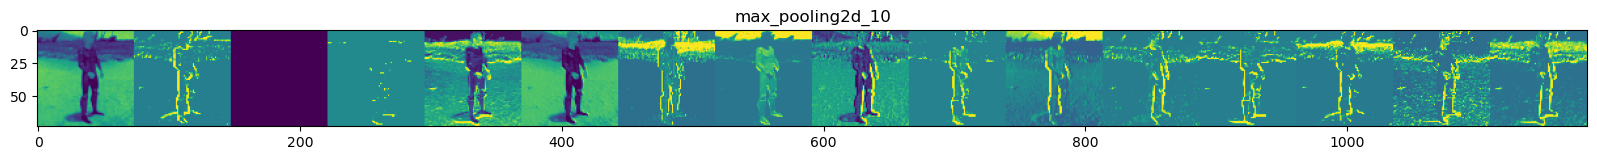

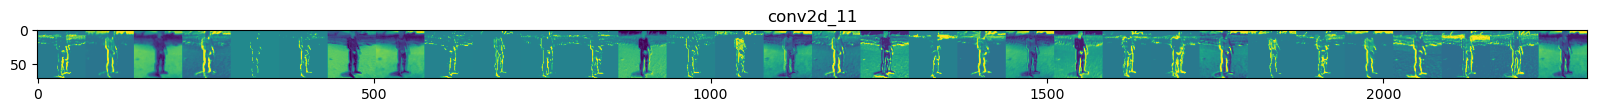

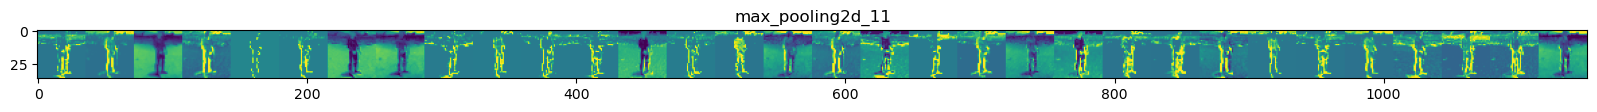

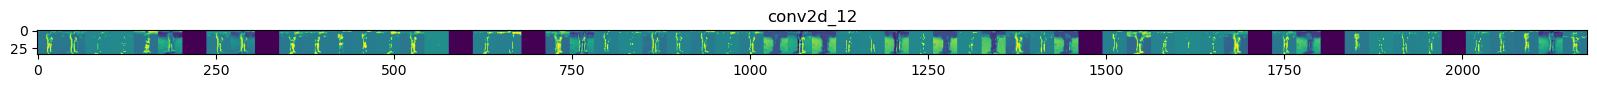

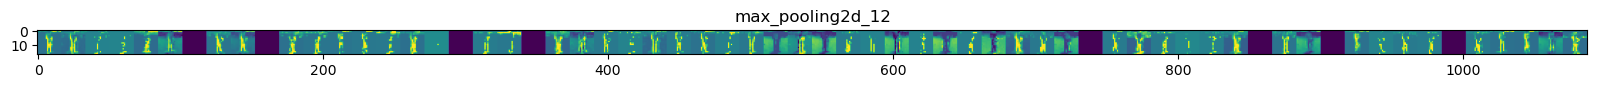

In [50]:
# Definindo um novo modelo que recebe uma imagem e tem como saída as
# representações intermediárias de cada camada no modelo anterior (com excessão da 1a)
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Preparando uma imagem aleatória do conjunto de treinamento
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = tf.keras.utils.load_img(img_path, target_size=(150, 150)) # Imagem do tipo PIL
x = tf.keras.utils.img_to_array(img)  # Vetor numpy de formato (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Vetor numpy de formato (1, 150, 150, 3)

# Reescala por 1/255
x = rescale_layer(x)

# Passa a imagem pela rede, obtendo todas as representações intermediárias para esta imagem
successive_feature_maps = visualization_model.predict(x, verbose=False)

# Obtendo os nomes das camadas para usar como título dos plots
layer_names = [layer.name for layer in model.layers[1:]]

# Plota as representações
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Pega somente as camadas de convolução e maxpool, e não as totalmente conectadas
        n_features = feature_map.shape[-1]  # number of features in feature map

        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')